In [594]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math 
from scipy.integrate import odeint
import os

In [595]:
main_path  = os.getcwd()

In [596]:
def find_reaction(a,asum,random):
    summ = 0
    found = False
    index = [0] #first reaction
    while found==False:
        for i in index:
            try:
                summ += a[i] #compute sum from first index up
            except: #if number of possible reactions exceeded, take last
                found=True 
                return index[-2]
        if summ>random*asum: #condition met
            found=True
            return index[-1]
        else:
            #add the following new index to the summation and try again
            index.append(index[-1]+1)

def deriv_sis(y, t, beta, gamma):
    S, I = y
    dSdt = gamma * I - beta * S * I 
    dIdt = beta * S * I - gamma * I
    return dSdt, dIdt


Equilibrium @ 1.00


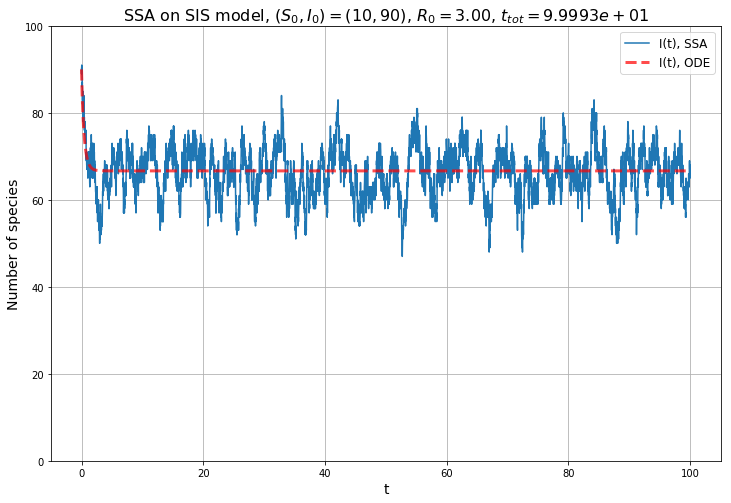

In [638]:
### Initial conditions
X = np.zeros(2) #two species
N = 100
vol = N

X0_0 = .1*N
X1_0 =  N-X0_0
X[0] = X0_0
X[1] = X1_0
a = np.zeros(2) #two reactions
V = np.array([[-1, 1], [1, -1]]) #stechiometric matrix
beta,gamma= 3,1

output_folder = main_path+"/Matlab/data_sis_v0/SSA"

### Start simulation SSA
history = [] #[t, X[0],X[1]]
t = 0
tau=0
t_end = 100
jlist = []
while t<t_end:
    history.append([t, X[0],X[1],tau]) # t, S, I, tau
    #evaluate propensities
    a[0] = beta * X[0] * X[1] / vol   #(X[0],X[1]) -> (X[0]-1,X[1]+1)
    a[1] = gamma * X[1]         #(X[0],X[1]) -> (X[0]+1,X[1]-1)
    asum = np.sum(a)

    #evaluate reaction and tau
    rand = np.random.uniform(size=2)
    tau = math.log(1/rand[1])/asum
    #naive
    #if rand[0] < a[0] / asum:
    #    j=0
    #else:
    #    j=1
    j=find_reaction(a,asum,rand[0])

    jlist.append(j)
    #print("Chosen reaction = %d"%(j))
    #Update
    X += V[:,j] 
    t = t+tau
    #exit condition: # of one of the species goes to zero
    if np.prod(X)==0:
        t=t_end

### SaveData SSA
history = pd.DataFrame(history)
history.to_csv(output_folder+"/%d_%d_%d_%.2e.csv" %(N,X0_0,X1_0,beta/gamma))


### Start ODE 
S0, I0 = X0_0/N, X1_0/N
y0 = S0, I0
t = np.linspace(0, 100, 1000)

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_sis, y0, t, args=(beta, gamma))
S, I = ret.T
if beta>gamma:
    print("Equilibrium @ %.2f"%(1-gamma/beta))
else:
    print("Exponential decay")

### Plot

#f, ax = plt.subplots(1, 1,figsize=(10,5))
plt.figure(figsize=(12,8))
plt.title("SSA on SIS model, $(S_{0},I_{0})=(%d,%d)$, $R_{0}=%.2f$, $t_{tot}=%.4e$"%(X0_0,X1_0,beta/gamma,history[0].iloc[-1]),fontsize=16)
#ax[0].plot(history[0],'b-')
#ax[0].grid()
#ax[0].set_xlabel("Iteration",fontsize=14)
#ax[0].set_ylabel("t(iteration)",fontsize=14)
#ax[0].semilogx()


plt.plot(history[0],history[2],label="I(t), SSA")
#plt.plot(history[0],history[1],label="S(t), SSA")
plt.plot(t,I*N,label="I(t), ODE",ls='--',color='red',alpha=.7,linewidth=3)
#plt.plot(t,S*N,label="S(t), ODE")

plt.legend(fontsize=12)
plt.xlabel("t",fontsize=14)
plt.ylabel("Number of species",fontsize=14)
plt.grid()
plt.ylim(0,N)

### SavePlot
plt.savefig(output_folder+"/%d_%d_%d_%.2e.png" %(N,X0_0,X1_0,beta/gamma))

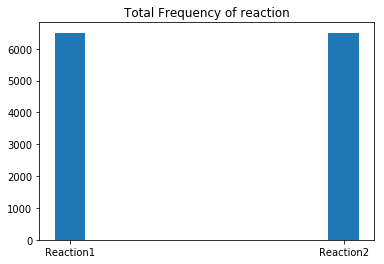

In [639]:
plt.title("Total Frequency of reaction")
plt.hist(jlist)
plt.xticks([0.05,.95],["Reaction1","Reaction2"])
plt.show()